In [3]:
import numpy as np
import pandas as pd
import networkx as nx
from matplotlib import pyplot as plt
from functools import lru_cache


In [4]:
NOTES = ["C", "C#", "D", "D#", "E", "F", "F#", "G", "G#", "A", "A#", "B"]

semitones = {k: NOTES[k] for k in range(12)}
inv_semitones = {NOTES[k]:k for k in range(12)}
fifths = {k: NOTES[k * 7 % 12] for k in range(12)}
inv_fifths = {NOTES[k * 7 % 12]:k for k in range(12)}

In [5]:
from multiprocessing.sharedctypes import Value


@lru_cache(maxsize=100)
def build_lookup_table(transformation_index):
    upper = [(2 * note_index + transformation_index) % 12 for note_index in range(6)]
    lower = [(transformation_index + 1 - 2 * note_index) % 12 for note_index in range(6)]
    inputs = upper + lower
    outputs = lower + upper
    return {input: output for (input, output) in zip(inputs, outputs)}

def transform_note(note, tranformation_index):
    lookup_table = build_lookup_table(tranformation_index)
    return fifths[lookup_table[inv_fifths[note]]]

def negative_harmony_transform_scale(scale, transformation_index):
    output_scale = [transform_note(note, transformation_index) for note in scale]
    return [output_scale[0]] + output_scale[::-1][:-1]

def permutation_transform_scale(scale):
    return [scale[-1]] + scale[:-1]

def get_interval_pattern(scale):
    ext = scale + [scale[0]]
    return [(inv_semitones[r] - inv_semitones[l]) % 12 for (l,r) in zip(ext, ext[1:])]

def get_scale_from_intervals(intervals):
    output = [semitones[k] for k in intervals]
    return output


In [6]:
scale_intervals = {
    "unison": [0],
    "minor pentatonic": [0, 3, 5, 7, 10],
    "major pentatonic": [0, 2, 4, 7, 9],
    "scottish pentatonic": [0, 2, 5, 7, 9],
    "blues minor": [0, 3, 5, 8, 10],
    "suspended pentatonic": [0, 2, 5, 7, 10],
    "lydian": [0, 2, 4, 6, 7, 9, 11],
    "ionian": [0, 2, 4, 5, 7, 9, 11],
    "mixolydian": [0, 2, 4, 5, 7, 9, 10],
    "dorian": [0, 2, 3, 5, 7, 9, 10],
    "aeolian": [0, 2, 3, 5, 7, 8, 10],
    "phrygian": [0, 1, 3, 5, 7, 8, 10],
    "locrian": [0, 1, 3, 5, 6, 8, 10],
    "harmonic minor": [0, 2, 3, 5, 7, 8, 11],
    "harmonic minor inverse": [0, 1, 4, 5, 7, 9, 10],
    "locrian natural 6": [0, 1, 3, 5, 6, 9, 10],
    "major augmented": [0, 2, 4, 5, 8, 9, 11],
    "lydian diminished": [0, 2, 3, 6, 7, 9, 10],
    "phrygian dominant": [0, 1, 4, 5, 7, 8, 10],
    "aeolian harmonic": [0, 3, 4, 6, 7, 9, 11],
    "ultralocrian": [0, 1, 3, 4, 6, 8, 9],
    "superlocrian": [0, 1, 3, 4, 6, 8, 10],
    "melodic minor": [0, 2, 3, 5, 7, 9, 11],
    "dorian b2": [0, 1, 3, 5, 7, 9, 10],
    "lydian b3": [0, 2, 3, 6, 7, 9, 11],
    "lydian augmented #2": [0, 3, 4, 6, 8, 9, 11],
    "locrian bb7": [0, 1, 3, 5, 6, 8, 9],
    "harmonic major": [0, 2, 4, 5, 7, 8, 11],
    "dorian b5": [0, 2, 3, 5, 6, 9, 10],
    "phrygian b4": [0, 1, 3, 4, 7, 8, 10],
    "minor locrian": [0, 2, 3, 5, 6, 8, 10],
    "major minor": [0, 2, 4, 5, 7, 8, 10],
    "lydian dominant": [0, 2, 4, 6, 7, 9, 10],
    "lydian augmented": [0, 2, 4, 6, 8, 9, 11],
    
}
inv_scale_intervals = {tuple(ks): name for (name, ks) in scale_intervals.items()}
scales = {name: get_scale_from_intervals(ks) for (name, ks) in scale_intervals.items()}
inv_scales = {tuple(ks): name for (name, ks) in scales.items()}
scale_interval_patterns = {name: get_interval_pattern(scale) for (name, scale) in scales.items()}
inv_scale_interval_patterns = {tuple(ks): name for (name, ks) in scale_interval_patterns.items()}

def identify_scale(scale):
    pattern = tuple(get_interval_pattern(scale))
    if pattern not in inv_scale_interval_patterns:
        raise ValueError(f"Pattern {pattern} unknown for scale {scale}, with intervals {[0] + list(np.cumsum(pattern))[:-1]}")
    return inv_scale_interval_patterns.get(pattern)

In [7]:
outputs = {}
for name, scale in scales.items():
    print(f"{name:20s}  ==> {set(identify_scale(negative_harmony_transform_scale(scale, k)) for k in range(6))}")
    print(f"{name:20s}  ==> {identify_scale(permutation_transform_scale(scale))}")

unison                ==> {'unison'}
unison                ==> unison
minor pentatonic      ==> {'scottish pentatonic'}
minor pentatonic      ==> scottish pentatonic
major pentatonic      ==> {'blues minor'}
major pentatonic      ==> minor pentatonic
scottish pentatonic   ==> {'minor pentatonic'}
scottish pentatonic   ==> blues minor
blues minor           ==> {'major pentatonic'}
blues minor           ==> suspended pentatonic
suspended pentatonic  ==> {'suspended pentatonic'}
suspended pentatonic  ==> major pentatonic
lydian                ==> {'locrian'}
lydian                ==> phrygian
ionian                ==> {'phrygian'}
ionian                ==> locrian
mixolydian            ==> {'aeolian'}
mixolydian            ==> lydian
dorian                ==> {'dorian'}
dorian                ==> ionian
aeolian               ==> {'mixolydian'}
aeolian               ==> mixolydian
phrygian              ==> {'ionian'}
phrygian              ==> dorian
locrian               ==> {'lydian'}
locr

In [8]:
stack = {"locrian"}

while True:
    current_length = len(stack)
    for item in stack:
        new_item = identify_scale(permutation_transform_scale(scales[item]))
        stack = stack | {new_item}
    if len(stack) == current_length:
        break
stack    

{'aeolian', 'dorian', 'ionian', 'locrian', 'lydian', 'mixolydian', 'phrygian'}

In [9]:
def make_graph(**scale_groups):
    G = nx.DiGraph()
    for (name, scale_group) in scale_groups.items():
        for scale in scale_group:
            G.add_node(scale, scale_group=name)
            neg_harm = identify_scale(negative_harmony_transform_scale(scales[scale], 0))
            permutts = identify_scale(permutation_transform_scale(scales[scale]))
            G.add_edge(scale, neg_harm, weight=10, kind="negative_harmony")
            G.add_edge(scale, permutts, weight=10, kind="mode_permutation")
    return G


def draw_graph(G, ax, positions, node_colorizer=None, edge_colorizer=None, rad=0.1, **options):
    if node_colorizer is not None:
        options["node_color"] = [node_colorizer(G._node[u]["scale_group"]) for u in G.nodes()]
    if edge_colorizer is not None:
        options["edge_color"] = [edge_colorizer(G[u][v]["kind"]) for (u, v) in G.edges()]
    nx.draw_networkx(G, pos=positions, ax=ax, connectionstyle=f"arc3,rad={rad}", **options)

In [10]:
greek_modes = ["lydian", "ionian", "mixolydian", "dorian", "aeolian", "phrygian", "locrian"]
melo_modes = ["superlocrian", "lydian dominant", "melodic minor", "major minor", "dorian b2", "minor locrian", "lydian augmented"]

harm_modes = ["harmonic minor", "ultralocrian", "aeolian harmonic", "phrygian dominant", "lydian diminished", "major augmented", "locrian natural 6"]
harm_inv_modes = ["harmonic minor inverse", "lydian b3", "phrygian b4", "dorian b5", "harmonic major", "locrian bb7", "lydian augmented #2"]

stack =  harm_modes + harm_inv_modes + greek_modes + melo_modes

In [11]:
options = {"font_size": 12, "node_size": 300, "linewidths": 0, "width": 1}
edge_colorizer = lambda edge: "indigo" if edge == "negative_harmony" else "tomato"
node_colorizer = lambda node: {"harmonic_minor_modes": "tomato", "harmonic_minor_inverse_modes": "steelblue", "greek_modes": "tomato", "melodic_minor_modes":"tomato"}.get(node, "tomato")

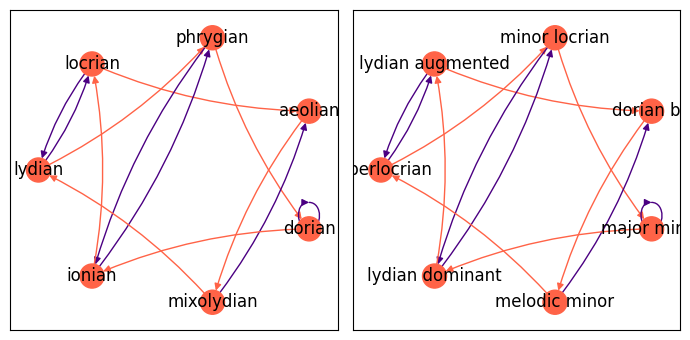

In [12]:
g_greek = make_graph(greek_modes=greek_modes)
g_melos = make_graph(melodic_minor_modes=melo_modes)

pos_greek = nx.shell_layout(g_greek, [greek_modes])
pos_melos = nx.shell_layout(g_melos, [melo_modes])
fig, ax = plt.subplots(figsize=(2*3.5, 3.5), ncols=2)
draw_graph(g_greek, ax[0], pos_greek, edge_colorizer=edge_colorizer, node_colorizer=node_colorizer)
draw_graph(g_melos, ax[1], pos_melos, edge_colorizer=edge_colorizer, node_colorizer=node_colorizer)
fig.tight_layout()
# fig.savefig("graph.png")


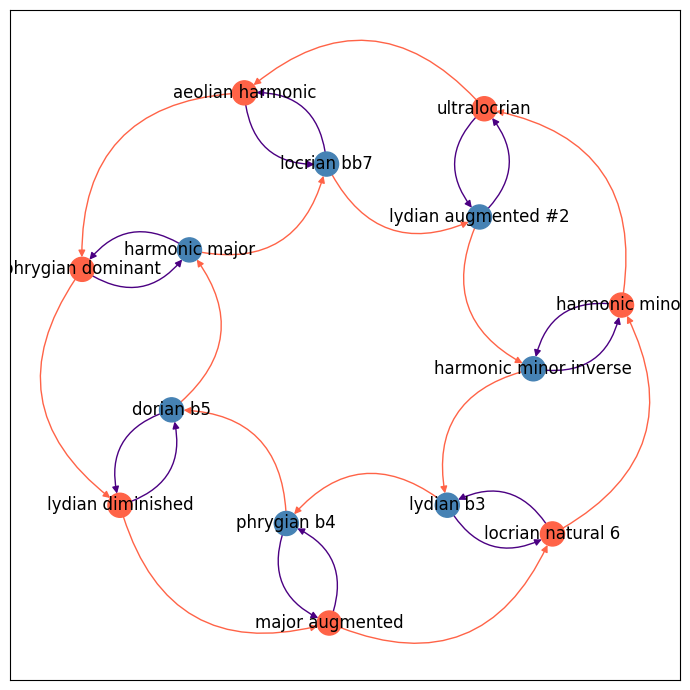

In [13]:
g_harm = make_graph(harmonic_minor_modes=harm_modes, harmonic_minor_inverse_modes=harm_inv_modes)
subg_harm_modes = nx.subgraph(g_harm, harm_modes)
subg_harm_inv_modes = nx.subgraph(g_harm, harm_inv_modes)

pos_harm_modes = nx.circular_layout(subg_harm_modes, scale=50)
pos_harm_inv_modes = nx.circular_layout(subg_harm_inv_modes, scale=20)
pos_harm = {**pos_harm_modes, **pos_harm_inv_modes}
pos_harm = nx.spring_layout(g_harm, pos=pos_harm, iterations=1)


fig, ax = plt.subplots(figsize=(7, 7))
draw_graph(g_harm, ax, pos_harm, edge_colorizer=edge_colorizer, node_colorizer=node_colorizer, rad=0.5)
fig.tight_layout()
# # fig.savefig("g_harm.png")

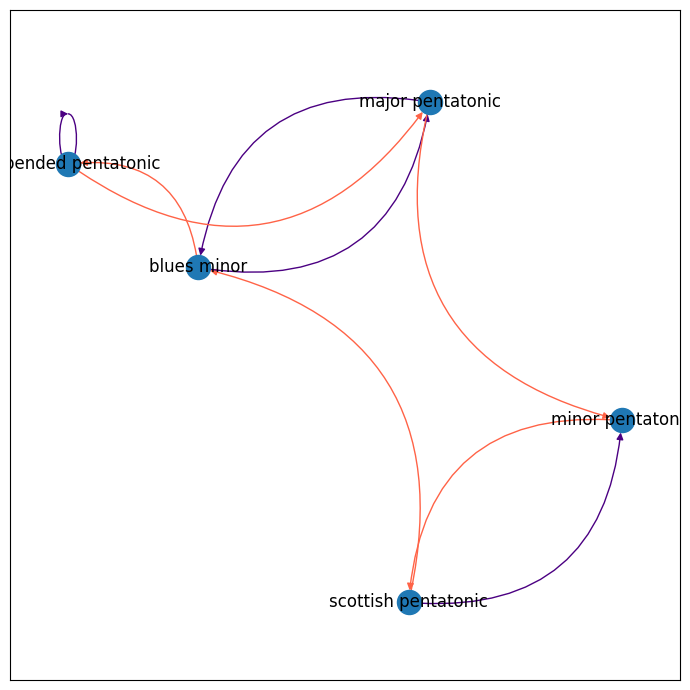

In [14]:
g = make_graph(pentatonics=["minor pentatonic", "scottish pentatonic", "blues minor", "major pentatonic", "suspended pentatonic"])
pos = nx.spring_layout(g, scale=50)


fig, ax = plt.subplots(figsize=(7, 7))
draw_graph(g, ax, pos, rad=0.5, edge_colorizer=edge_colorizer)
fig.tight_layout()
# # fig.savefig("g_harm.png")

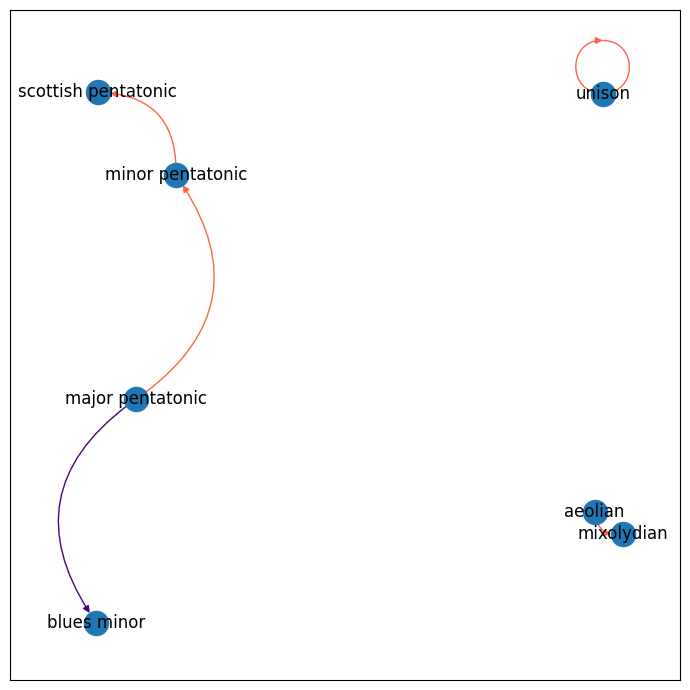

In [15]:
g = make_graph(unison=["aeolian", "unison", "minor pentatonic", "major pentatonic"])
pos = nx.spring_layout(g, scale=50)


fig, ax = plt.subplots(figsize=(7, 7))
draw_graph(g, ax, pos, rad=0.5, edge_colorizer=edge_colorizer)
fig.tight_layout()
# # fig.savefig("g_harm.png")